In [1]:
import os

xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

import bernstein_coeff_order10_arbitinterval, bernstein_coeff_ordern_arbitinterval
from functools import partial
import numpy as np
import jax.numpy as jnp
import mujoco
import mujoco.mjx as mjx 
import jax
import time

from mjx_planner import cem_planner

In [2]:
num_dof = 6
num_batch = 500
num_steps = 50
maxiter_projection = 5
maxiter_cem = 2
w_pos = 1
w_rot = 0.5
w_col = 10
num_elite = 0.05
timestep = 0.05
max_joint_pos = np.pi 
max_joint_vel=1.0
max_joint_acc=2.0
max_joint_jerk=4.0

start_time = time.time()
#opt_class = cem_planner(num_dof, num_batch, w_pos=3, num_elite=0.1, maxiter_cem=30)	
opt_class = cem_planner(num_dof=num_dof, num_batch=num_batch, num_steps=num_steps, maxiter_cem=maxiter_cem,
                        w_pos=w_pos, w_rot=w_rot, w_col=w_col, num_elite=num_elite, timestep=timestep,
                        maxiter_projection=maxiter_projection,
                        max_joint_pos = max_joint_pos, max_joint_vel=max_joint_vel, max_joint_acc=max_joint_acc, 
                        max_joint_jerk=max_joint_jerk)


start_time_comp_cem = time.time()
xi_mean = jnp.zeros(opt_class.nvar)
xi_cov = 10.0*jnp.identity(opt_class.nvar)
xi_samples, key = opt_class.compute_xi_samples(opt_class.key, xi_mean, xi_cov)  


/home/alinjar/custom_env/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:132: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


ngeomm 42
167 / 195 contacts involve considered geoms.

 Default backend: gpu
 Model path: /home/alinjar/manipulator/manipulator_mujoco/sampling_based_planner/ur5e_hande_mjx/scene.xml 
 Timestep: 0.05 
 CEM Iter: 2 
 Projection Iter: 5 
 Number of batches: 500 
 Number of steps per trajectory: 50 
 Time per trajectory: 2.5 
 Number of variables: 300 
 Number of Total constraints: 2364 
 Number of geomteric IDs for colllision: 10


In [3]:
#init_pos = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
init_pos = jnp.array([1.5, -1.8, 1.75, -1.25, -1.6, 0])
# init_pos = jnp.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
init_vel = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
init_acc = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
target_pos = jnp.array([0.0, 0.0, 0.0])
target_rot = jnp.array([0.0, 0.0, 0.0, 1.0])
s_init = jnp.zeros((opt_class.num_batch, opt_class.num_total_constraints))
lamda_init = jnp.zeros((opt_class.num_batch, opt_class.nvar))

cost, best_cost_g, best_cost_r, best_cost_c, best_vels, best_traj, \
xi_mean, xi_cov, thd_all, th_all, avg_primal_res, avg_fixed_res, \
primal_res, fixed_res, _ = opt_class.compute_cem(
    xi_mean,
    xi_cov,
    init_pos,
    init_vel,
    init_acc,
    target_pos,
    target_rot,
    lamda_init,
    s_init,
    xi_samples
)

print(f"best_vels: {best_vels.shape}")
print(f"Total time: {round(time.time()-start_time, 2)}s")
print(f"Compute CEM time: {round(time.time()-start_time_comp_cem, 2)}s")
    

best_vels: (50, 6)
Total time: 36.37s
Compute CEM time: 23.18s


In [4]:
print(opt_class.Pint.shape)
print(opt_class.P.shape)

# print(opt_class.Pint)
# print(opt_class.P)
# print(opt_class.Pdot)

# initi = np.vstack((opt_class.Pint[0], opt_class.P[0], opt_class.Pdot[0], opt_class.P[-1], opt_class.Pdot[-1]  ))

# print(initi.shape)
# print(initi)

(50, 50)
(50, 50)


(50, 6)


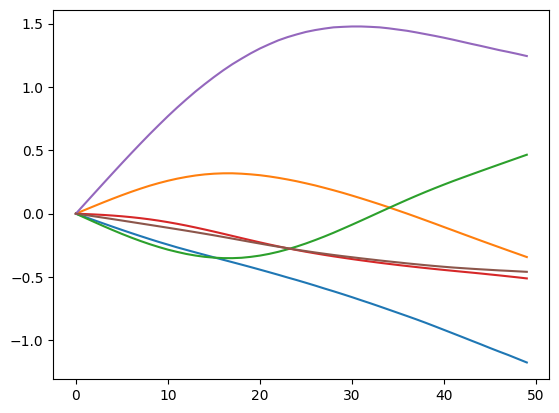

In [5]:
print(best_vels.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(best_vels)
plt.show()



(2, 500, 300)


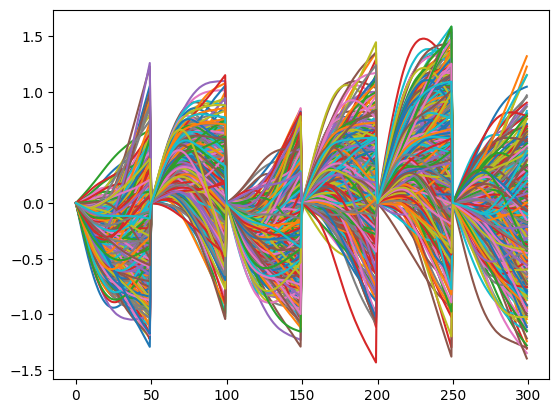

In [6]:
print(thd_all.shape)



%matplotlib inline
plt.figure()
plt.plot(thd_all[-1].T)
plt.show()


(500, 1)
(500, 1)


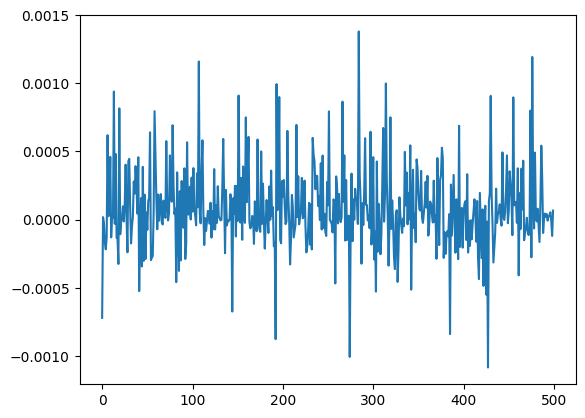

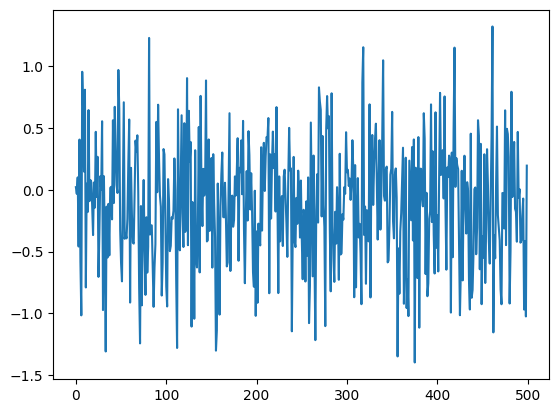

In [7]:
vel_start = np.zeros((num_batch, 1))
vel_end = np.zeros((num_batch, 1))

for i in range(num_batch):
    vel_start[i] = thd_all[-1][i][0]
    vel_end[i] = thd_all[-1][i][-1]

print(vel_start.shape)
print(vel_end.shape)

%matplotlib inline

plt.figure()
plt.plot(vel_start)
plt.show()

plt.figure()
plt.plot(vel_end)
plt.show()




(2, 500, 300)


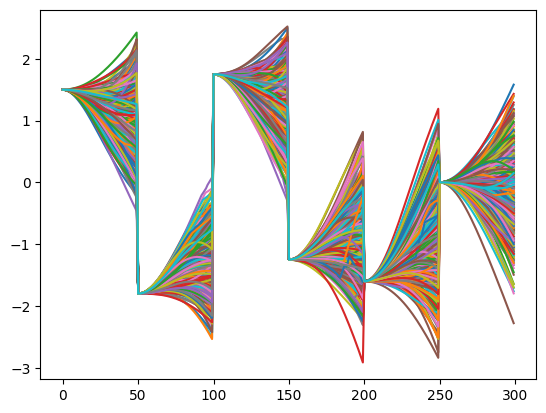

In [8]:
print(th_all.shape)
%matplotlib inline
plt.figure()
plt.plot(th_all[-1].T)
plt.show()

(500, 1)
(500, 1)


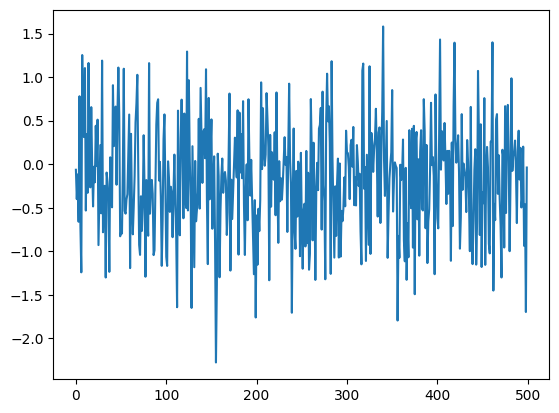

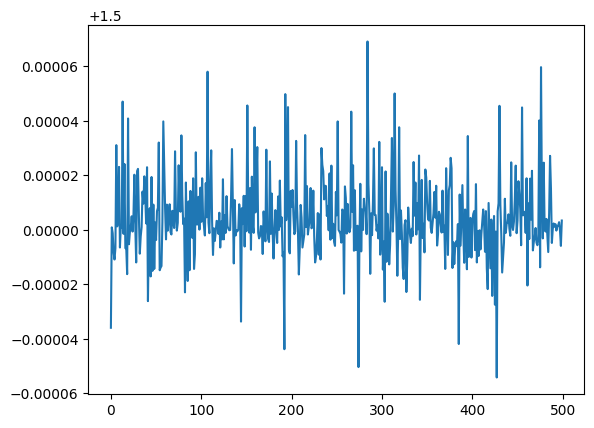

In [9]:
theta_start = np.zeros((num_batch, 1))
theta_end = np.zeros((num_batch, 1))

for i in range(num_batch):
    theta_start[i] = th_all[-1][i][0]
    theta_end[i] = th_all[-1][i][-1]

print(theta_start.shape)
print(theta_end.shape)

%matplotlib inline
plt.figure()
plt.plot(theta_end)
plt.show()

plt.figure()
plt.plot(theta_start)
plt.show()

In [10]:
print(primal_res.shape)
print(fixed_res.shape)

print(avg_primal_res.shape)
print(avg_fixed_res.shape)

(2, 5, 500)
(2, 5, 500)
(2, 500)
(2, 500)


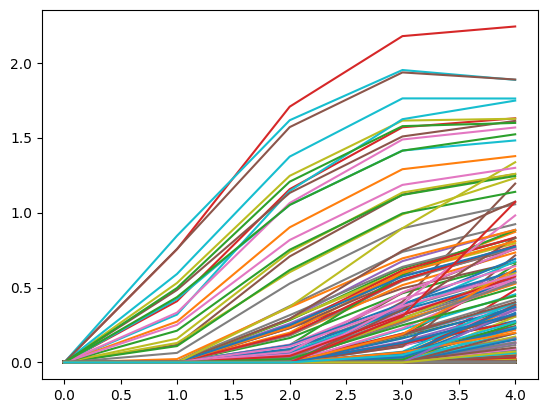

In [11]:
%matplotlib inline
plt.figure()
plt.plot(primal_res[-1])
plt.show()

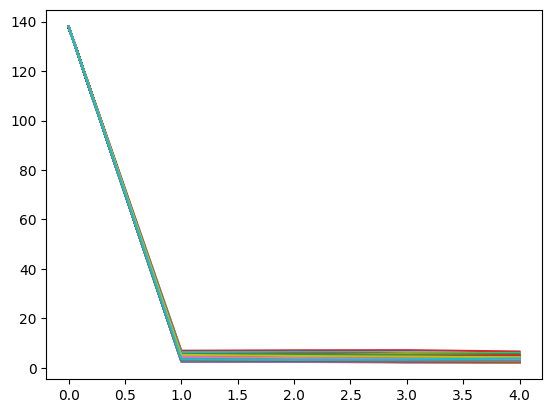

: 

In [ ]:
%matplotlib inline
plt.figure()
plt.plot(fixed_res[-1])
plt.show()